# Wind Impact on PID Leashless Agent Performance

How robust is the PID without the safety leash to all wind?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent
from multirotor.helpers import DataLog
from trajectories import nasa_wp
from parameters import pid_params

In [2]:
best_agent = PIDAgent()
pos_mult = 1
vel_mult = 1
pid_parameters = pid_params(
    pos_p=[pos_mult*0.3, pos_mult*0.3, 0.2],
    vel_p=[vel_mult*1, vel_mult*1, 100],
    vel_i=[vel_mult*0.1, vel_mult*0.1, 0]
)

best_params = {'steps_u':1, 'scaling_factor':0, 'window_distance':1000, 'pid_parameters': pid_parameters}

In [3]:
env_selector = OctorotorEnvSelector()
square_wpts = np.array([[100,0,30], [100,100,30], [0,100,30], [0,0,30]])
triangle_wpts = np.array([[50,100,30], [-50, 100,30], [0,0,30]])


In [4]:
def get_tte(initial_pos: tuple, waypoints: np.ndarray, x: np.ndarray, y:np.ndarray, z:np.ndarray) -> np.ndarray:
        """
        Calculates the trajectory tracking error. 
        The distance between the current point and the vector between previous and next wp. Uses ||v1 x v2|| / ||v1||.

        Parameters
        ----------
        initial_pos : tuple  
            the initial position of the UAV.
        waypoints : np.ndarray 
            the reference positions at each point in time.
        x : np.ndarray 
            the x positions of the UAV.
        y : np.ndarray 
            the y positions of the UAV.
        z : np.ndarray
            the z positions of the UAV.

        Returns
        -------
        np.ndarray 
            the trajectory tracking error at each point in time.
        """
        ttes = []
        prev = initial_pos
        for i, waypoint in enumerate(waypoints):
            if i > 0 and not np.array_equal(waypoints[i-1], waypoints[i]):
                prev = waypoints[i-1]

            v1 = waypoint - prev
            v2 = np.array([x[i],y[i],z[i]]) - prev
            tte = np.linalg.norm(np.cross(v1, v2)) / (np.linalg.norm(v1) + 1e-6)
            ttes.append(tte)
                
        return np.array(ttes)

In [5]:
def toc(tte: np.ndarray):
    corridor = 2
    return best_params['steps_u'] * len(tte[tte > corridor]) / 100

In [6]:
def completed_mission(waypoints: np.ndarray, x: np.ndarray, y: np.ndarray, z: np.ndarray, radius: float = 0.65):
        for waypoint in waypoints:
            reached_waypoint = False

            for position in zip(x,y,z):
                dist = np.linalg.norm(waypoint - position)

                if dist <= radius:
                    reached_waypoint = True
                    break

            if not reached_waypoint:
                return False
            
        return True

In [7]:
def run_trajectory(env_selector, wind_ranges: np.ndarray, agent, params):
    wp = [(150,0,30)]
    env = env_selector.get_env("default", params, wind_ranges, square_wpts, start_alt=30, has_turbulence=True)
    env.base_env.proximity = 2
    # env.base_env.max_velocity = 10
    
    done = False
    state = np.array(env.reset(), dtype=np.float32)
    log = DataLog(env.base_env.vehicle,
                      other_vars=('reward', 'next_wp', 'wind', 'motor', 'vel'))
    while not done:
        action = agent.predict(state, deterministic=True)[0]
        state, reward, done, info = env.step(action)
        state = np.array(state, dtype=np.float32)
        log.log(reward=reward, next_wp=env.base_env.next_waypt, wind=env.base_env.wind_x, motor=env.base_env.vehicle.speeds, vel=env.base_env.vehicle.velocity)

    log.done_logging()
    return log, info

In [8]:
wind_mag=12
log, info = run_trajectory(env_selector, [(0,0),(wind_mag,wind_mag),(0,0)], best_agent, best_params)

In [9]:
def save_video_data(log, tte):
    X = log.x
    Y = log.y
    Z = log.z
    
    roll = log.roll
    pitch = log.pitch
    yaw = log.yaw
    
    wp_x = log.next_wp[:,0]
    wp_y = log.next_wp[:,1]
    wp_z = log.next_wp[:,2]
    
    data_array = np.vstack([X, Y, Z, roll, pitch, yaw, wp_x, wp_y, wp_z, tte]).T
    df = pd.DataFrame(data_array, columns=[['X', 'Y', 'Z', 'Roll', 'Pitch', 'Yaw', 'WPX', 'WPY', 'WPZ', 'TTE']])
    df.to_csv('./data/sample_data.csv')

In [10]:
# save_video_data(log, get_tte([0,0,30], log.next_wp, log.x, log.y, log.z))

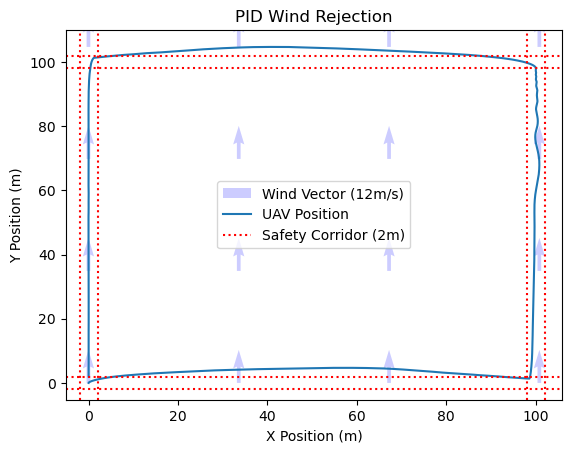

In [11]:
# Generate some example data
x = np.linspace(np.min(log.x), np.max(log.x), 4)
y = np.linspace(np.min(log.y), np.max(log.y), 4)
X, Y = np.meshgrid(x, y)
U = np.zeros_like(X)  # All arrows pointing right
V = np.ones_like(Y)

# Plot the vector field
plt.quiver(X, Y, U, V, scale=15, color='blue', alpha=0.2, label=f'Wind Vector ({wind_mag}m/s)')

plt.plot(log.x, log.y, label='UAV Position')
# plt.xlim(90,110)
# plt.ylim(-10,10)
plt.axvline(x=98, ymin=0, ymax=100, linestyle=':', color='red')
plt.axvline(x=102, ymin=0, ymax=100, linestyle=':', color='red')
plt.axvline(x=-2, ymin=0, ymax=100, linestyle=':', color='red')
plt.axvline(x=2, ymin=0, ymax=100, linestyle=':', color='red')

plt.axhline(y=98, xmin=0, xmax=100, linestyle=':', color='red')
plt.axhline(y=102, xmin=0, xmax=100, linestyle=':', color='red')
plt.axhline(y=-2, xmin=0, xmax=100, linestyle=':', color='red')
plt.axhline(y=2, xmin=0, xmax=100, linestyle=':', color='red', label='Safety Corridor (2m)')
plt.title("PID Wind Rejection")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.legend()

In [12]:
toc(get_tte([0,0,30], log.next_wp, log.x, log.y, log.z))

20.22

In [13]:
len(log.x) / 100

123.21

In [14]:
np.max(get_tte([0,0,30], log.next_wp, log.x, log.y, log.z))

4.708918196447295

In [15]:
len(log.t) / 100

123.21

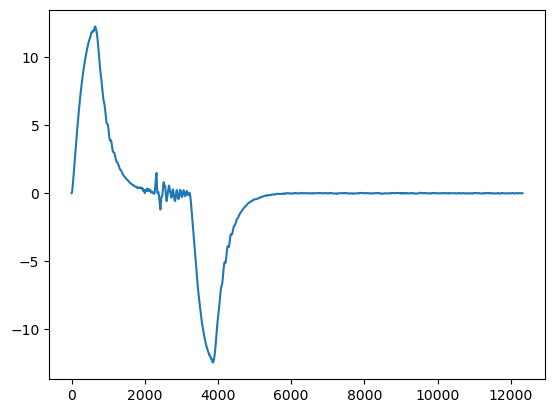

In [16]:
plt.plot(log.vel[:,0])

In [17]:
max(log.velocity[:,0])

12.250377

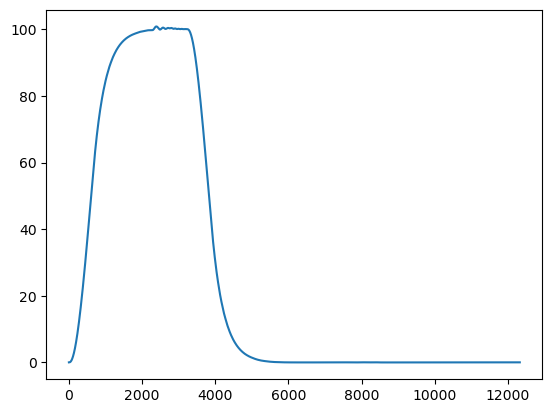

In [18]:
plt.plot(log.x)

In [19]:
wind_range_dict = {
    'zero': [(0,0), (0,0), (0,0)],
    'n5': [(0,0), (5,5), (0,0)],
    'n7': [(0,0), (7,7), (0,0)],
    'n10': [(0,0), (10,10), (0,0)],
    'n12': [(0,0), (12,12), (0,0)],
    's5': [(0,0), (-5,-5), (0,0)],
    's7': [(0,0), (-7,-7), (0,0)],
    's10': [(0,0), (-10,-10), (0,0)],
    's12': [(0,0), (-12,-12), (0,0)],
    'e5': [(5,5), (0,0), (0,0)],
    'e7': [(7,7), (0,0), (0,0)],
    'e10': [(10,10), (0,0), (0,0)],
    'e12': [(12,12), (0,0), (0,0)],
    'w5': [(-5,-5), (0,0), (0,0)],
    'w7': [(-7,-7), (0,0), (0,0)],
    'w10': [(-10,-10), (0,0), (0,0)],
    'w12': [(-12,-12), (0,0), (0,0)],
    'nw5': [(-3.53553391,-3.53553391), (3.53553391,3.53553391), (0,0)],
    'nw7': [(-4.94974747,-4.94974747), (4.94974747,4.94974747), (0,0)],
    'nw10': [(-7.07106781,-7.07106781), (7.07106781,7.07106781), (0,0)],
    'nw12': [(-8.5,-8.5), (8.5,8.5), (0,0)],
    'sw5': [(-3.53553391,-3.53553391), (-3.53553391,-3.53553391), (0,0)],
    'sw7': [(-4.94974747,-4.94974747), (-4.94974747,-4.94974747), (0,0)],
    'sw10': [(-7.07106781,-7.07106781), (-7.07106781,-7.07106781), (0,0)],
    'sw12': [(-8.5,-8.5), (-8.5,-8.5), (0,0)],
    'ne5': [(3.53553391,3.53553391), (3.53553391,3.53553391), (0,0)],
    'ne7': [(4.94974747,4.94974747), (4.94974747,4.94974747), (0,0)],
    'ne10': [(7.07106781,7.07106781), (7.07106781,7.07106781), (0,0)],
    'ne12': [(8.5,8.5), (8.5,8.5), (0,0)],
    'se5': [(3.53553391,3.53553391), (-3.53553391,-3.53553391), (0,0)],
    'se7': [(4.94974747,4.94974747), (-4.94974747,-4.94974747), (0,0)],
    'se10': [(7.07106781,7.07106781), (-7.07106781,-7.07106781), (0,0)],
    'se12': [(8.5,8.5), (-8.5,-8.5), (0,0)],
}

In [20]:
wind_results = pd.DataFrame(columns=['Wind', 'Total TTE', 'Mean TTE', 'Max TTE', 'Completed Mission', 'Reward', 'Time Outside Corridor'])

In [21]:
def run_wind_sweep(results, wind_dict, agent, params):
    for wind in tqdm(wind_dict.keys()):
        log, info = run_trajectory(env_selector, wind_dict[wind], agent, params)
        traj_err = get_tte(np.array([0,0,30]), log.next_wp, log.x, log.y, log.z)
        new_result = {
            'Wind': wind,
            'Mean TTE': np.mean(traj_err),
            'Total TTE': np.sum(traj_err),
            'Max TTE': np.max(traj_err),
            'Completed Mission': completed_mission(square_wpts, log.x, log.y, log.z, radius=5),
            'Reward': np.sum(log.reward),
            'Time Outside Corridor': toc(traj_err)
        }
        results = pd.concat([results, pd.DataFrame([new_result])], ignore_index=True)

    return results

In [22]:
wind_results = run_wind_sweep(wind_results, wind_range_dict, best_agent, best_params)

  0%|          | 0/33 [00:00<?, ?it/s]/tmp/ipykernel_4141312/2507324404.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([new_result])], ignore_index=True)
100%|██████████| 33/33 [06:54<00:00, 12.56s/it]


In [23]:
wind_results.to_csv('./data/pid_noleash_wind.csv')

In [24]:
wind_results = pd.read_csv('./data/pid_noleash_wind.csv') 

In [25]:
wind_results

,Unnamed: 0,Wind,Total TTE,Mean TTE,Max TTE,Completed Mission,Reward,Time Outside Corridor
0,0,zero,3052.123248,0.452099,1.996282,True,9390.7050,0.00
1,1,n5,3251.726609,0.470583,1.995474,True,9350.7560,0.00
2,2,n7,3994.212427,0.553598,1.993452,True,9202.1860,0.00
3,3,n10,7250.945175,0.868065,3.504885,True,8550.5430,11.75
4,4,n12,10039.205621,0.984719,4.830850,True,7992.6196,19.30
5,5,s5,3638.092674,0.522039,1.997009,True,9273.4920,0.00
6,6,s7,4802.393750,0.668485,2.347703,True,9040.5530,4.96
7,7,s10,7988.625694,0.968084,3.566078,True,8403.0470,14.71
8,8,s12,10897.406315,1.041021,4.896284,True,7821.0293,20.68
9,9,e5,3481.314230,0.504831,1.995926,True,9304.8650,0.00


In [26]:
print("Mean reward for 5 m/s: ", wind_results[wind_results['Wind'].str.contains("5")]['Reward'].mean())
print("Std reward for 5 m/s: ",wind_results[wind_results['Wind'].str.contains("5")]['Reward'].std())
print("Mean reward for 7 m/s: ", wind_results[wind_results['Wind'].str.contains("7")]['Reward'].mean())
print("Std reward for 7 m/s: ",wind_results[wind_results['Wind'].str.contains("7")]['Reward'].std())
print("Mean reward for 10 m/s: ", wind_results[wind_results['Wind'].str.contains("10")]['Reward'].mean())
print("Std reward for 10 m/s: ",wind_results[wind_results['Wind'].str.contains("10")]['Reward'].std())

Mean reward for 5 m/s:  9316.425749999999
Std reward for 5 m/s:  41.21408950398968
Mean reward for 7 m/s:  9102.465124999999
Std reward for 7 m/s:  52.06203571958991
Mean reward for 10 m/s:  8317.1613375
Std reward for 10 m/s:  200.9063548354871


In [27]:
print("Mean for 5 m/s: ", wind_results[wind_results['Wind'].str.contains("5")]['Mean TTE'].mean())
print("Std for 5 m/s: ",wind_results[wind_results['Wind'].str.contains("5")]['Mean TTE'].std())
print("Mean for 7 m/s: ", wind_results[wind_results['Wind'].str.contains("7")]['Mean TTE'].mean())
print("Std for 7 m/s: ",wind_results[wind_results['Wind'].str.contains("7")]['Mean TTE'].std())
print("Mean for 10 m/s: ", wind_results[wind_results['Wind'].str.contains("10")]['Mean TTE'].mean())
print("Std for 10 m/s: ",wind_results[wind_results['Wind'].str.contains("10")]['Mean TTE'].std())
print("Mean for 12 m/s: ", wind_results[wind_results['Wind'].str.contains("12")]['Mean TTE'].mean())
print("Std for 12 m/s: ",wind_results[wind_results['Wind'].str.contains("12")]['Mean TTE'].std())


Mean for 5 m/s:  0.494035997667277
Std for 5 m/s:  0.028874638191712133
Mean for 7 m/s:  0.6286846857639128
Std for 7 m/s:  0.03861094839516605
Mean for 10 m/s:  1.0614537066599392
Std for 10 m/s:  0.16200330631919388
Mean for 12 m/s:  1.3788975133898769
Std for 12 m/s:  0.44025562693737874


In [28]:
print("Mean reward for 5 m/s: ", wind_results[wind_results['Wind'].str.contains("5")]['Time Outside Corridor'].mean())
print("Std reward for 5 m/s: ",wind_results[wind_results['Wind'].str.contains("5")]['Time Outside Corridor'].std())
print("Mean reward for 7 m/s: ", wind_results[wind_results['Wind'].str.contains("7")]['Time Outside Corridor'].mean())
print("Std reward for 7 m/s: ",wind_results[wind_results['Wind'].str.contains("7")]['Time Outside Corridor'].std())
print("Mean reward for 10 m/s: ", wind_results[wind_results['Wind'].str.contains("10")]['Time Outside Corridor'].mean())
print("Std reward for 10 m/s: ",wind_results[wind_results['Wind'].str.contains("10")]['Time Outside Corridor'].std())
print("Mean reward for 12 m/s: ", wind_results[wind_results['Wind'].str.contains("12")]['Time Outside Corridor'].mean())
print("Std reward for 12 m/s: ",wind_results[wind_results['Wind'].str.contains("12")]['Time Outside Corridor'].std())

Mean reward for 5 m/s:  0.0
Std reward for 5 m/s:  0.0
Mean reward for 7 m/s:  1.585
Std reward for 7 m/s:  2.2229902641005235
Mean reward for 10 m/s:  12.8575
Std reward for 10 m/s:  4.115166200427736
Mean reward for 12 m/s:  26.59125
Std reward for 12 m/s:  7.329393733454356


In [29]:
print("Mean reward for 5 m/s: ", wind_results[wind_results['Wind'].str.contains("5")]['Completed Mission'].mean())
print("Std reward for 5 m/s: ",wind_results[wind_results['Wind'].str.contains("5")]['Completed Mission'].std())
print("Mean reward for 7 m/s: ", wind_results[wind_results['Wind'].str.contains("7")]['Completed Mission'].mean())
print("Std reward for 7 m/s: ",wind_results[wind_results['Wind'].str.contains("7")]['Completed Mission'].std())
print("Mean reward for 10 m/s: ", wind_results[wind_results['Wind'].str.contains("10")]['Completed Mission'].mean())
print("Std reward for 10 m/s: ",wind_results[wind_results['Wind'].str.contains("10")]['Completed Mission'].std())

Mean reward for 5 m/s:  1.0
Std reward for 5 m/s:  0.0
Mean reward for 7 m/s:  1.0
Std reward for 7 m/s:  0.0
Mean reward for 10 m/s:  1.0
Std reward for 10 m/s:  0.0
